In [1]:
%load_ext autoreload
%autoreload 2

In [55]:
from datetime import date
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sentence_transformers.util import semantic_search
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import sys

plastics_path = '/Users/ckruse/Documents/earthrise/plastics'
if plastics_path in sys.path:
    sys.path.remove('/Users/ckruse/Documents/earthrise/plastics')
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from scripts import dl_utils
from scripts import viz_tools

In [3]:
resolution = 25

"""
input_data_files = ['caroni_negative',
                    'caroni_positive',
                    'additional_negative',
                    'v1_caroni_0.95_thresh',
                    'v1_caroni_0.4-0.5_thresh',
                    'tapajos_v3_0.48-0.5_69',
                    'tapajos_v3_0.4-0.6_121',
                    'tapajos_v4_0.7-0.9_235',
                    'tapajos_2016_cloudy_outliers_190',
                    'tapajos_2016_outliers_187',
                    'corrupted',
                    'amazonas_north_v6-2020_thresh_0.1_0.3-1_170',
                    'amazonas_north_v6-2020_thresh_0.1_0.5-1_154',
                    'amazonas_north_v6-2020_thresh_0.1_0.8-1_125',
                    #'bolivar_2020_v7_thresh_0.5_0.6-0.8_89',
                    'bolivar_amazonas_v7_validated_negatives_220',
                    'bolivar_amazonas_v7_validated_positives_934',
                    'bolivar_amazonas_v7_validated_cloudy_negatives_448'
                   ]
"""

input_data_files = ['amazonas_2020_thresh_0.5postraining_patches_2020-01-01_2020-07-01_28px',
                    'amazonas_2020_thresh_0.5negtraining_patches_2020-01-01_2020-07-01_28px',
                    'MinesNeg2018-2020Sentinel_patches_2020-01-01_2020-07-01_28px',
                    'MinesPos2018-2020Sentinel_patches_2020-01-01_2020-07-01_28px',
                    'bolivar_2020_thresh_0.8negtraining_patches_2020-01-01_2020-07-01_28px',
                    'bolivar_2020_thresh_0.8postraining_patches_2020-01-01_2020-07-01_28px',
                    'bolivar_2020-06_negatives_patches_2020-01-01_2020-07-01_28px',
                    '28_px_bolivar_amazonas_v7_validated_cloudy_negatives_448',
                    '28_px_corrupted'
                   ]

images = []
labels = []

data_dir = os.path.join('..', 'data', 'training_data')

for fname in input_data_files:
    with open(os.path.join(data_dir, fname + '_patches.pkl'), 'rb') as f:
        data = pickle.load(f)
        for elem in data:
            patch = dl_utils.pad_patch(elem, resolution)
            images.append(patch)
    with open(os.path.join(data_dir, fname + '_patch_labels.pkl'), 'rb') as f:
        label = pickle.load(f)
        labels = np.concatenate((labels, label))

images = np.array(images)
print(len(images), "samples loaded")
print(sum(labels == 1), "positive samples")
print(sum(labels == 0), "negative samples")

5528 samples loaded
1359 positive samples
4169 negative samples


In [216]:
def compute_ndvi(pixel_arrays):
    return (pixel_arrays[:,:,7] - pixel_arrays[:,:,3]) / (pixel_arrays[:,:,7] + pixel_arrays[:,:,3])

In [217]:
positive_images = images[labels == 1]

In [237]:
positive_ndvi = [np.sum(compute_ndvi(image) > 0.6) / np.size(image[:,:,0]) for image in positive_images]
print(np.sum(np.array(positive_ndvi) > 0.5))

106


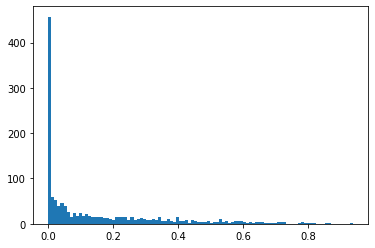

In [238]:
plt.hist(positive_ndvi, bins=100);

In [240]:
ndvi_positives = positive_images[np.array(positive_ndvi) > 0.5]

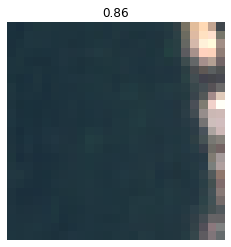

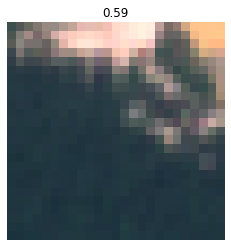

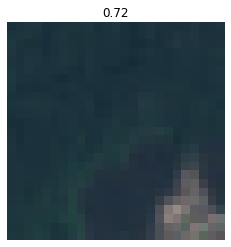

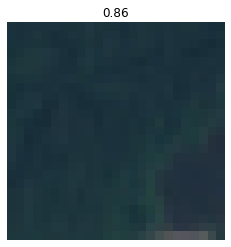

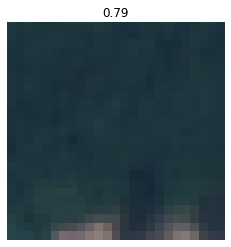

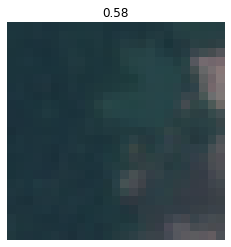

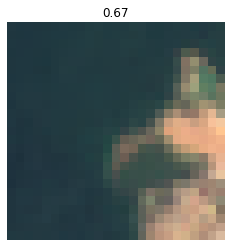

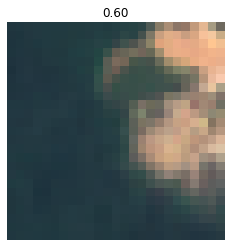

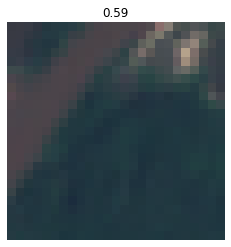

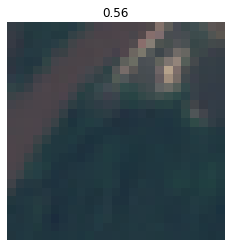

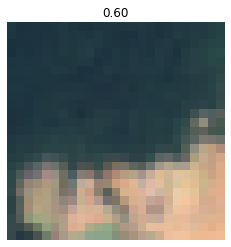

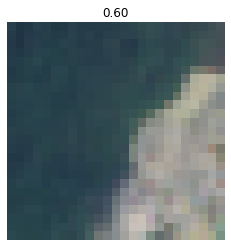

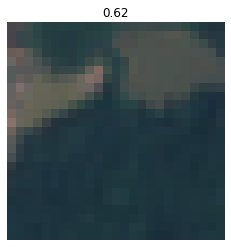

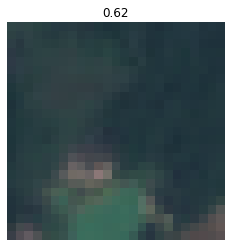

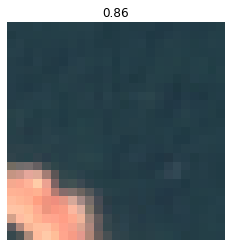

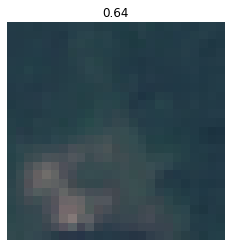

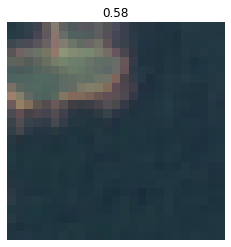

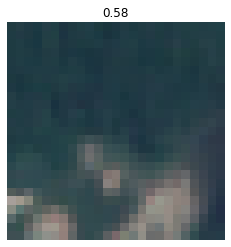

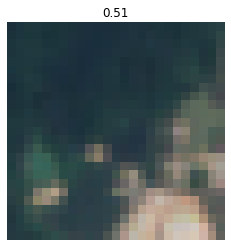

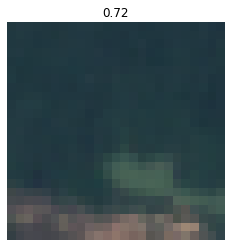

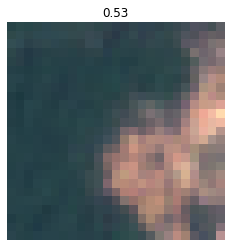

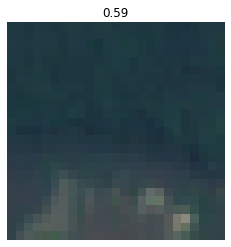

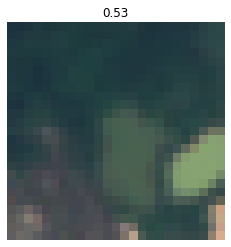

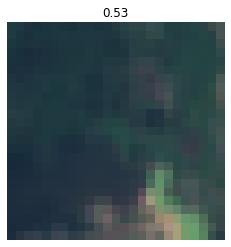

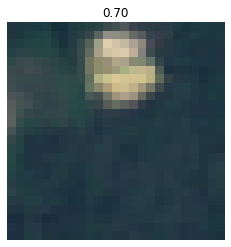

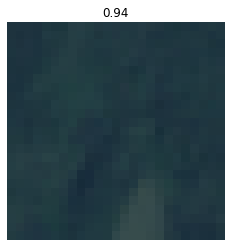

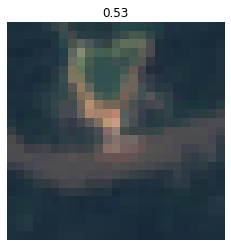

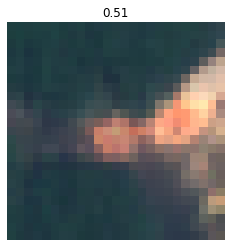

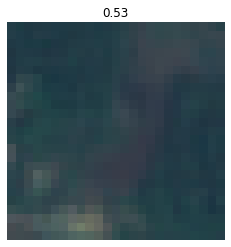

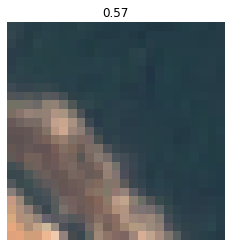

In [241]:
for i in range(30):
    sample_num = i
    plt.imshow(np.clip(ndvi_positives[sample_num][:,:,3:0:-1] / 3000, 0, 1))
    plt.axis('off')
    sample_ndvi = np.sum(compute_ndvi(ndvi_positives[sample_num]) > 0.6) / np.size(ndvi_positives[sample_num][:,:,0])
    plt.title(f"{sample_ndvi:.2f}")
    plt.show()

In [460]:
#for RGBIR, x = normalize(images[:,:,:,[1,2,3,8]])
positive_images = images[labels == 1]
x = dl_utils.normalize(np.copy(images))
y = keras.utils.to_categorical(labels, 2)

In [461]:
model = keras.models.load_model('../models/25px_v1.1_2021-06-11.h5')

In [462]:
threshold = 0.8
preds = model.predict(x)[:,1]
binary_preds = preds > threshold
failures = np.nonzero(binary_preds != labels.astype(bool))[0]
print(f"{len(failures)} failures out of {len(x)} samples ({len(failures) / len(x):.1%})")

213 failures out of 5528 samples (3.9%)


In [473]:
feat_extract = keras.Model(model.inputs, model.layers[4].output)
feat_extract.output_shape

(None, 64)

In [474]:
features = feat_extract.predict(np.clip(x, 0, 1))
features = np.array([feat.flatten() for feat in features])

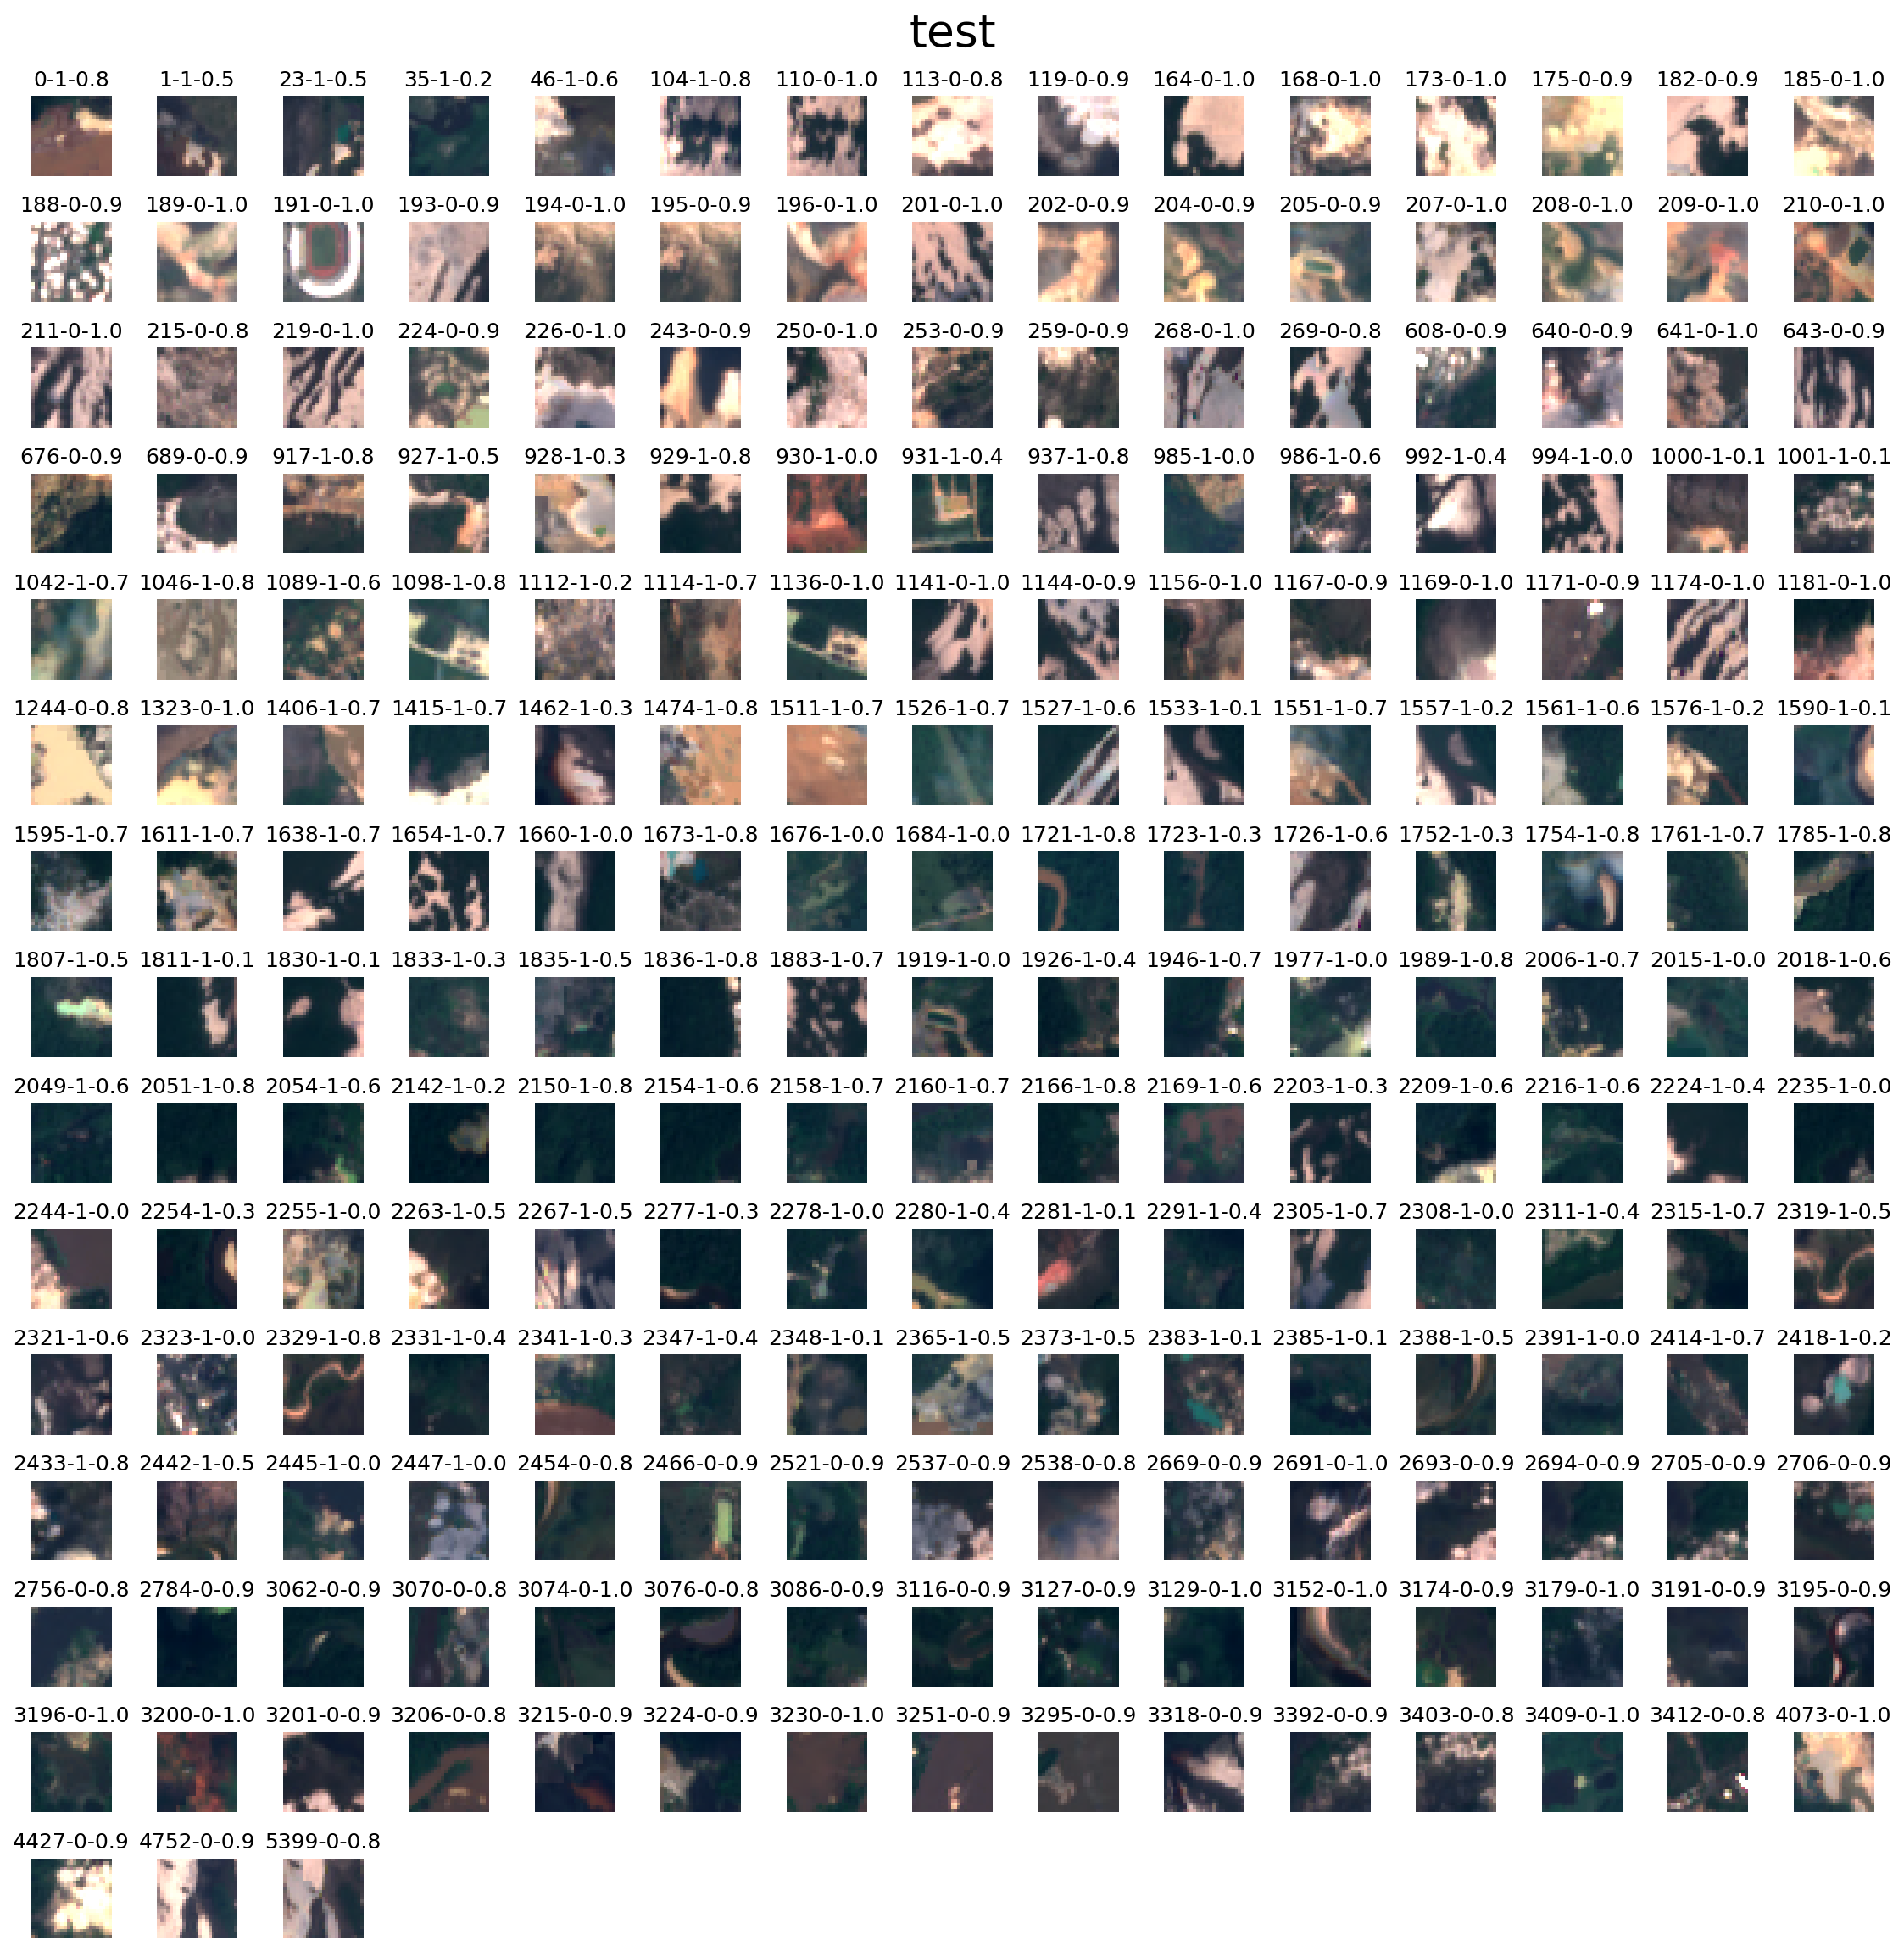

In [440]:
viz_tools.plot_similar_images(images[failures], 'test', save=False, labels=[f"{index}-{int(label)}-{pred:.1f}" for index, label, pred in zip(failures, labels[failures], preds[failures])])

100%|██████████| 213/213 [00:04<00:00, 46.84it/s]


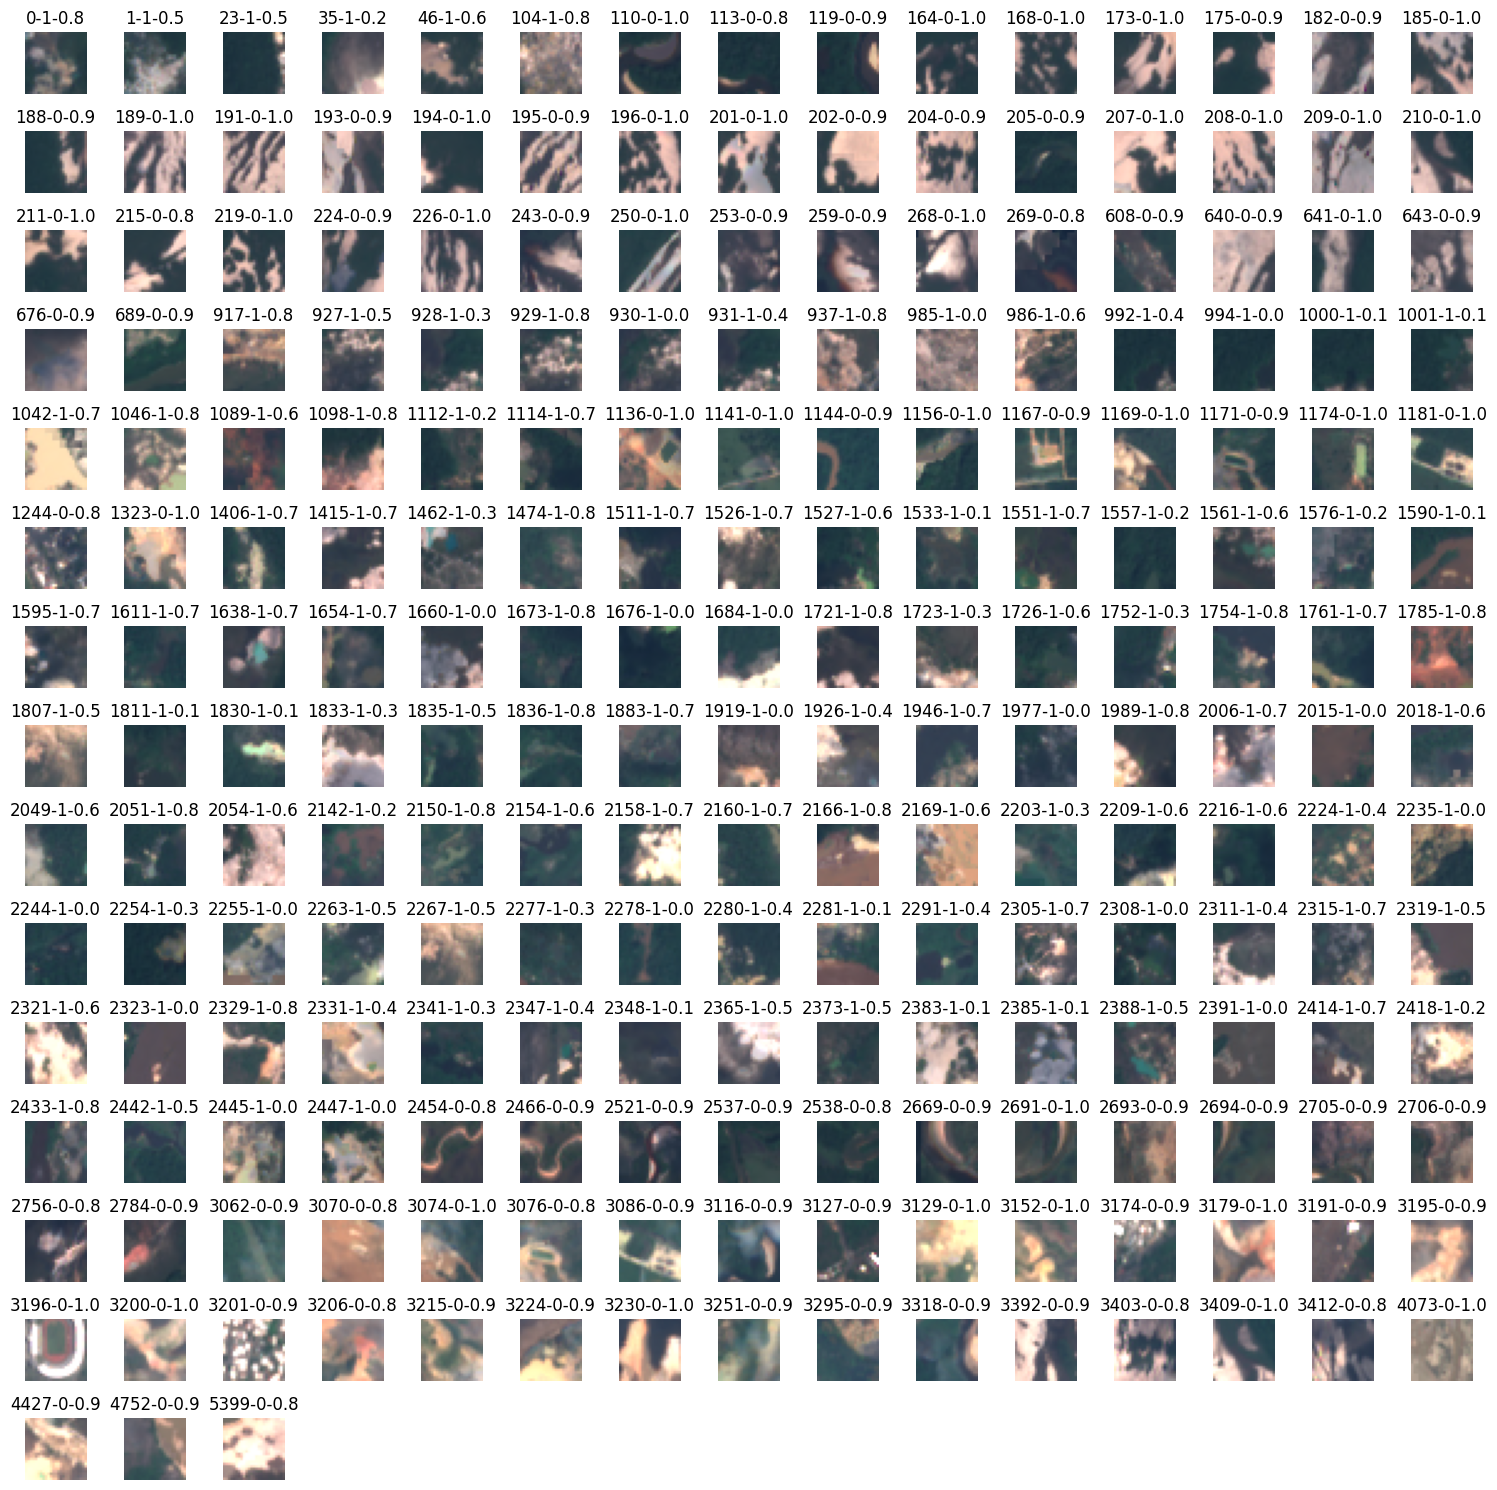

In [465]:
viz_tools.plot_image_grid(images[failures], labels=[f"{index}-{int(label)}-{pred:.1f}" for index, label, pred in zip(failures, labels[failures], preds[failures])])

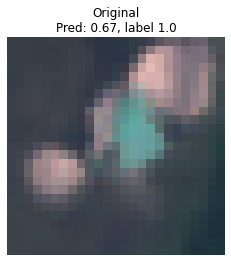

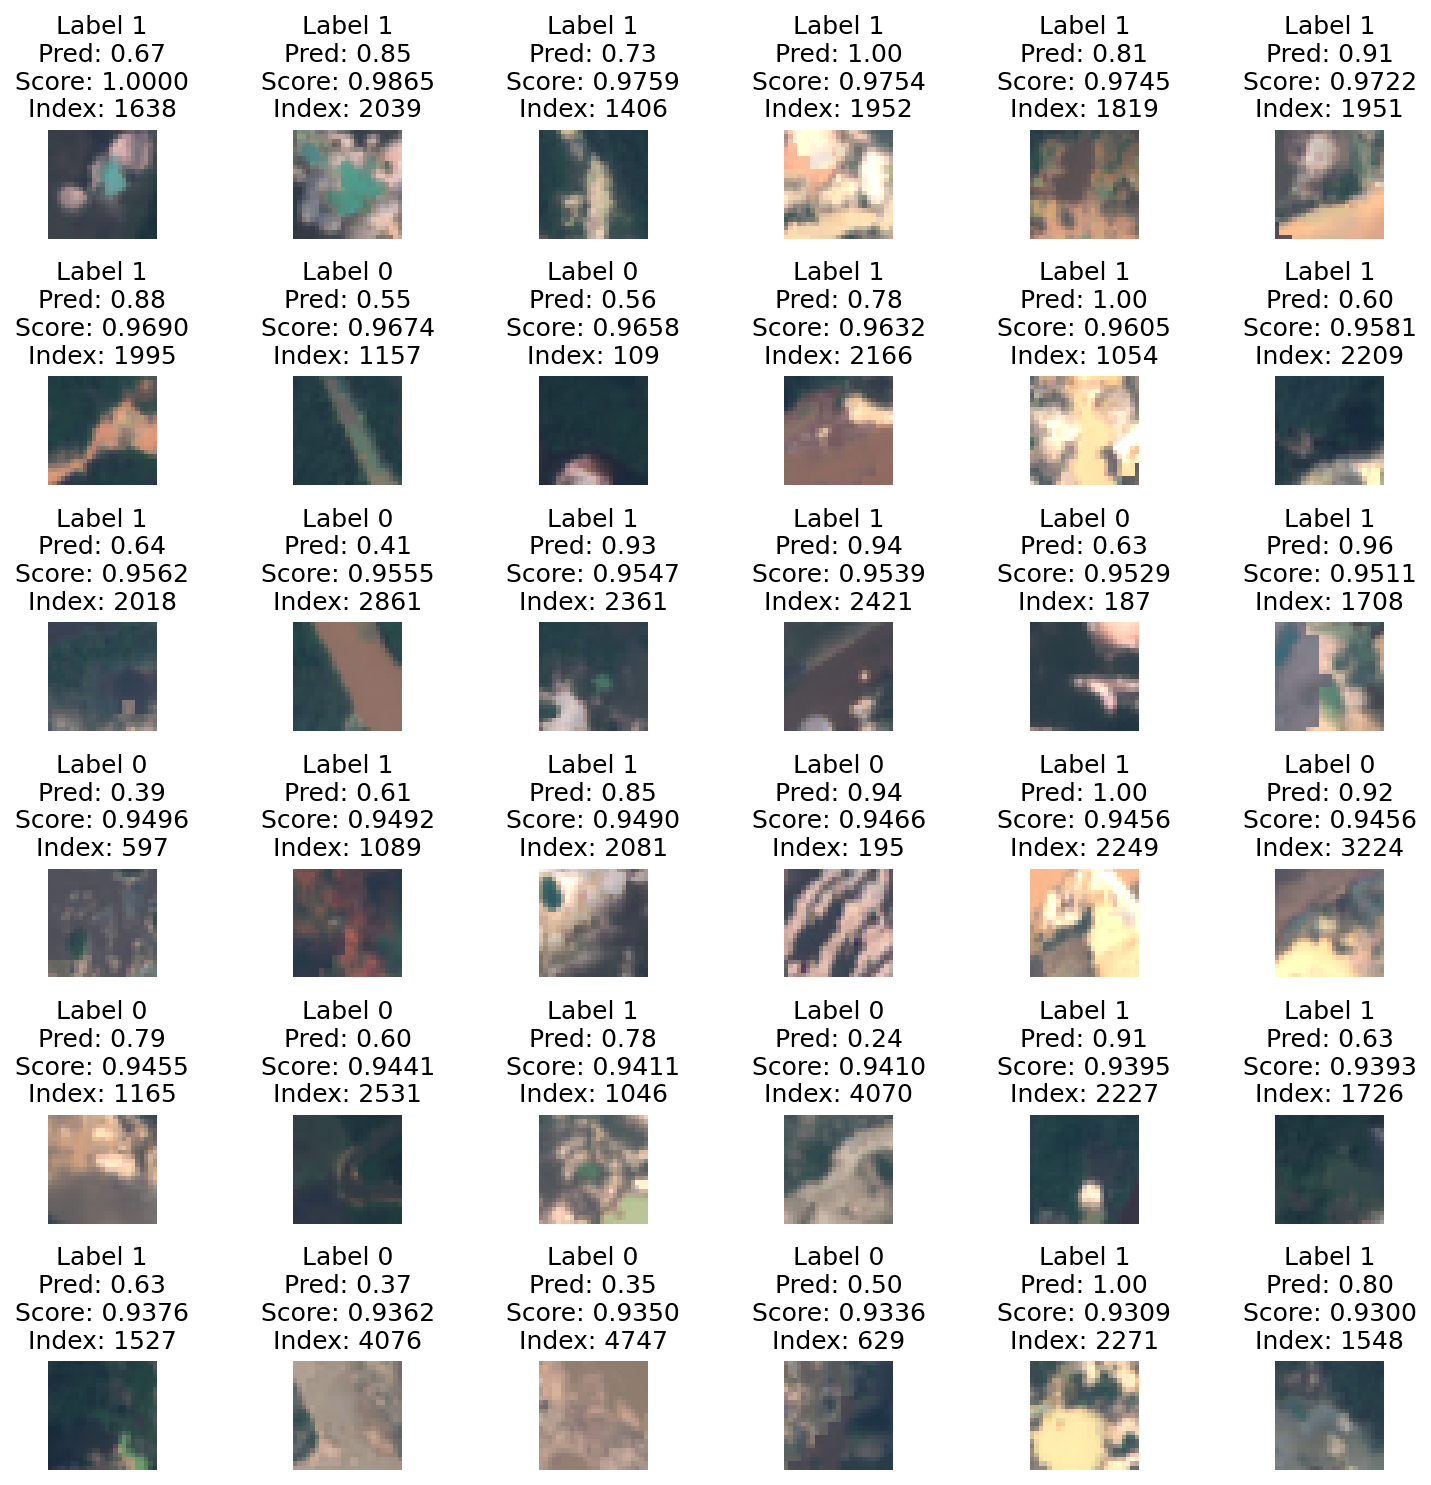

In [475]:

sample_id = 1638
num_samples = 6
matches = semantic_search(features[sample_id], features, top_k=num_samples ** 2)
plt.imshow(np.clip(x[sample_id][:,:,3:0:-1], 0, 1))
plt.title(f"Original\nPred: {preds[sample_id]:.2f}, label {labels[sample_id]}")
plt.axis('off')
plt.show()
plt.figure(figsize=(10,10), dpi=150)
for index, match in enumerate(matches[0]):
    match_id = match['corpus_id']
    #print(match_id, match['score'])
    plt.subplot(num_samples, num_samples, index + 1)
    plt.imshow(np.clip(x[match_id][:,:,3:0:-1], 0, 1))
    plt.title(f"Label {int(labels[match_id])}\nPred: {preds[match_id]:.2f}\nScore: {match['score']:.4f}\nIndex: {match_id}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [418]:
good_matches = []
for failure in failures:
    matches = semantic_search(features[failure], features, top_k=len(x))
    scores = [match['score'] for match in matches[0]]
    good_matches.append(np.sum(np.array(scores) > 0.9))

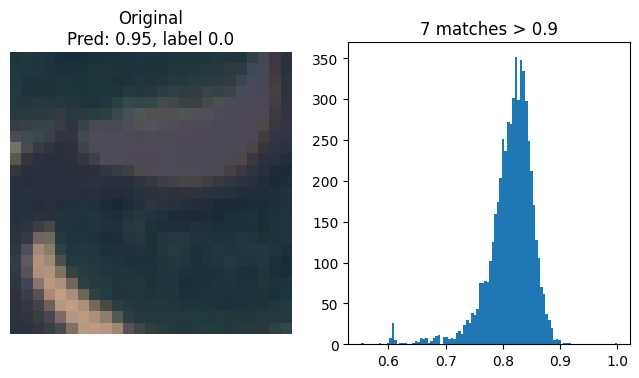

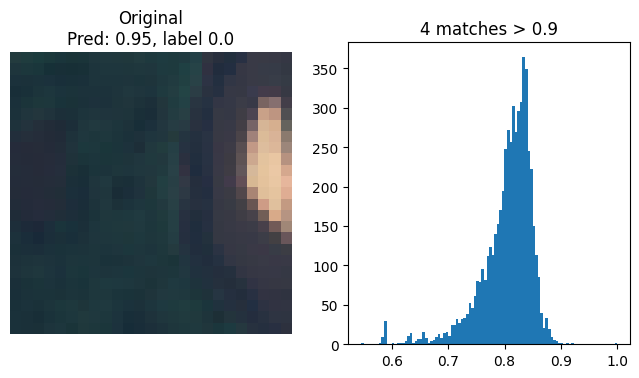

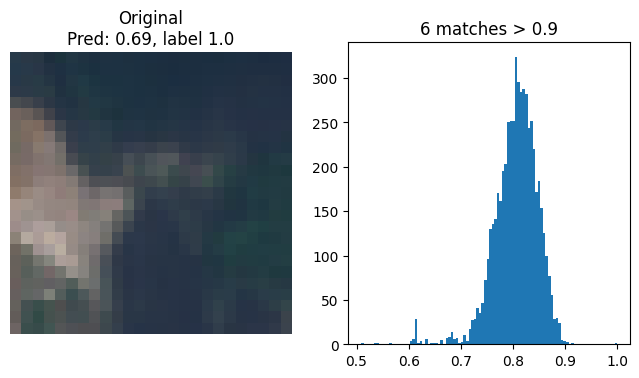

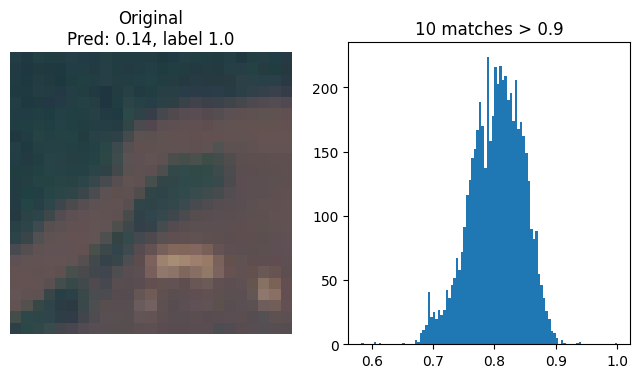

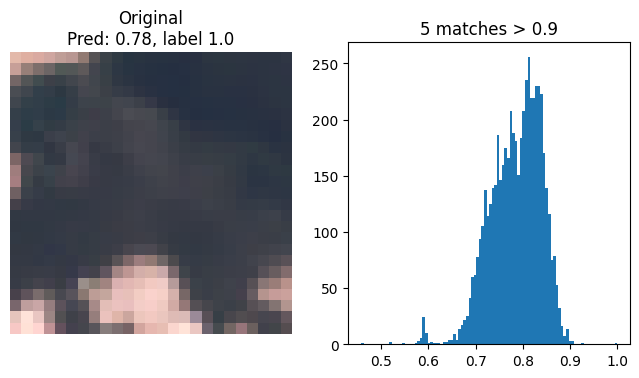

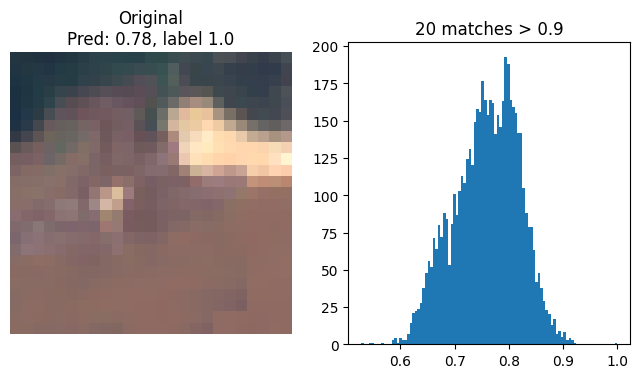

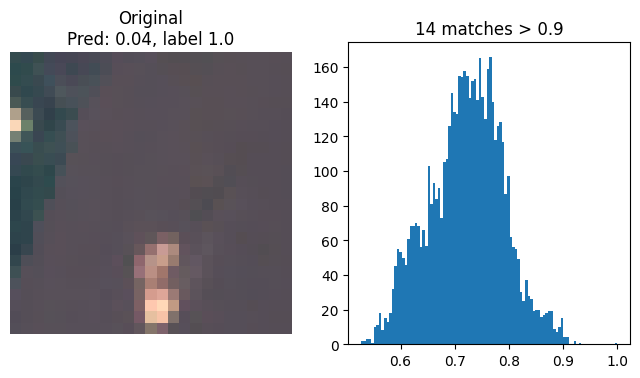

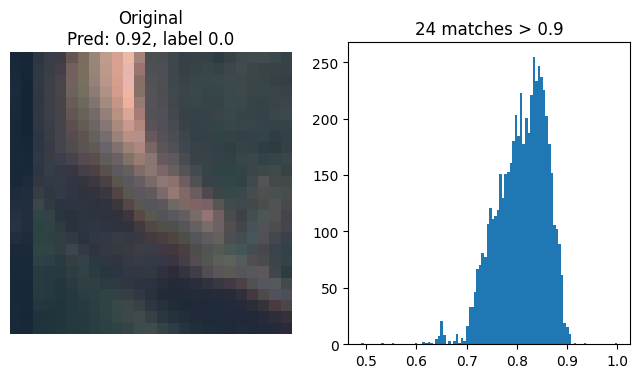

In [419]:
for elem in np.where(np.array(good_matches) < 30)[0]:
    sample_id = failures[elem]
    plt.figure(figsize=(8,4), dpi=100)
    plt.subplot(1,2,1)
    plt.imshow(np.clip(x[sample_id][:,:,3:0:-1], 0, 1))
    plt.title(f"Original\nPred: {preds[sample_id]:.2f}, label {labels[sample_id]}")
    plt.axis('off')
    plt.subplot(1,2,2)
    num_samples = len(x)
    matches = semantic_search(features[sample_id], features, top_k=num_samples)
    scores = [match['score'] for match in matches[0]]
    plt.hist(scores, 100)
    plt.title(f"{np.sum(np.array(scores) > 0.9)} matches > 0.9")
    plt.show()

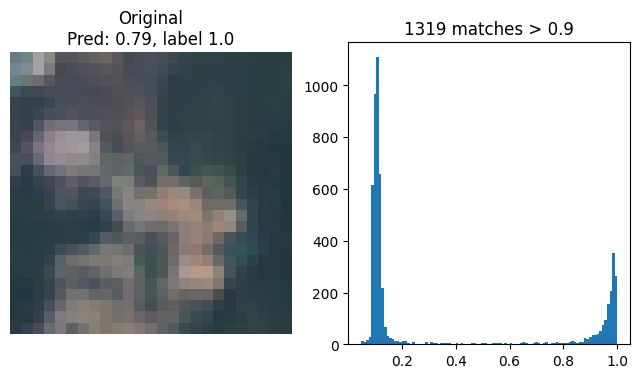

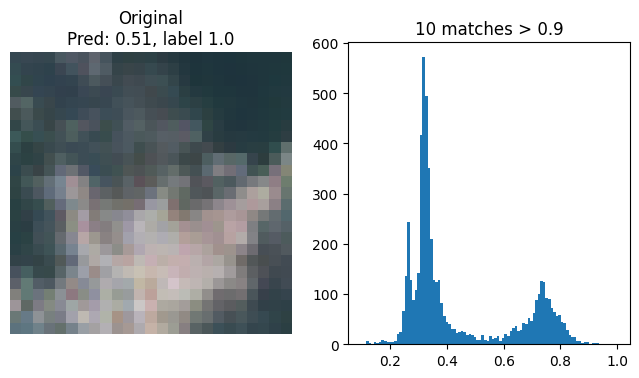

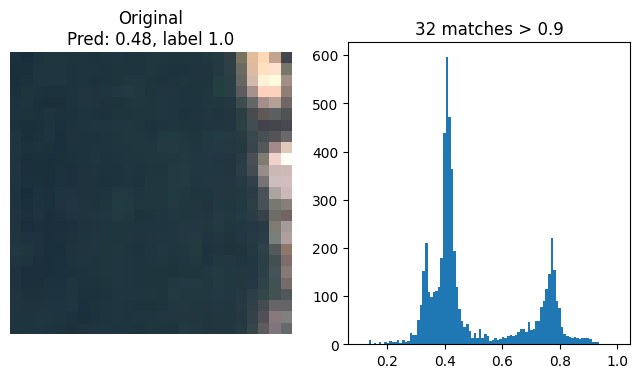

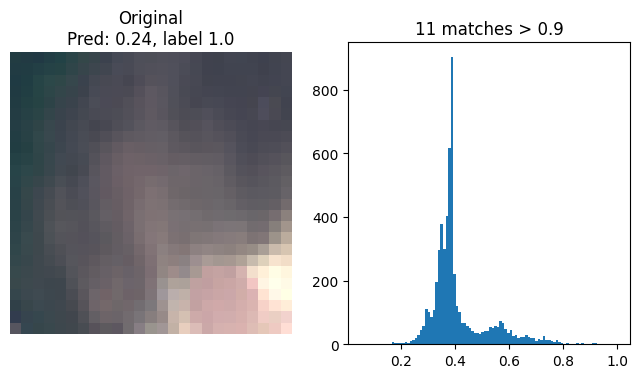

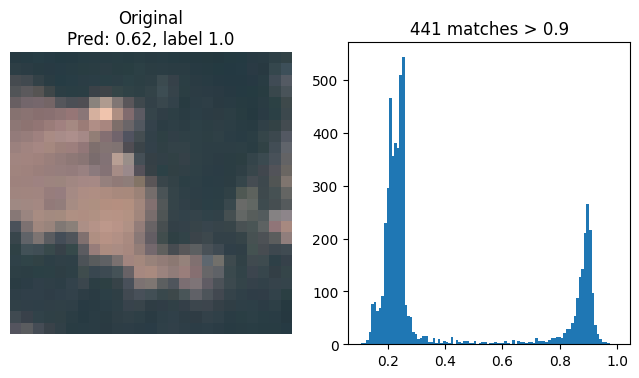

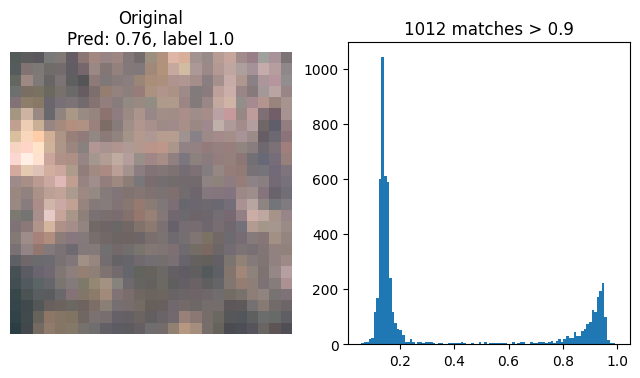

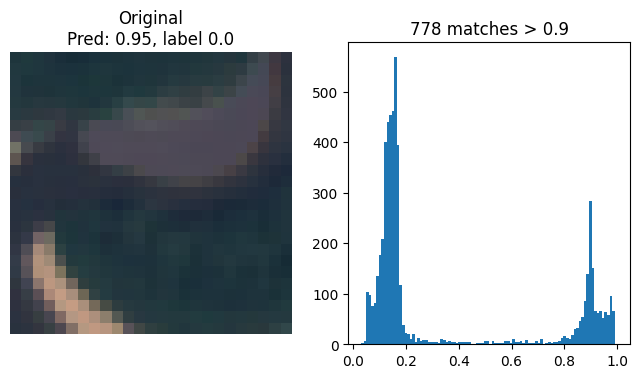

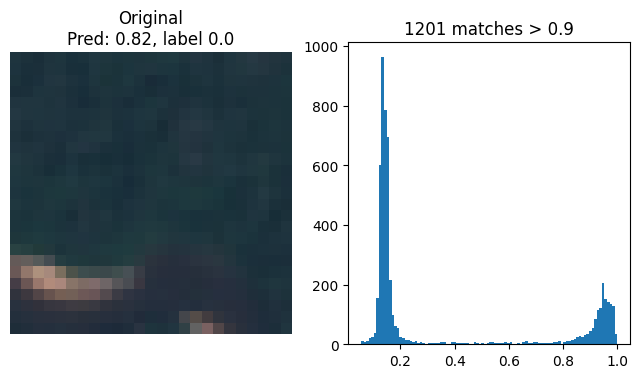

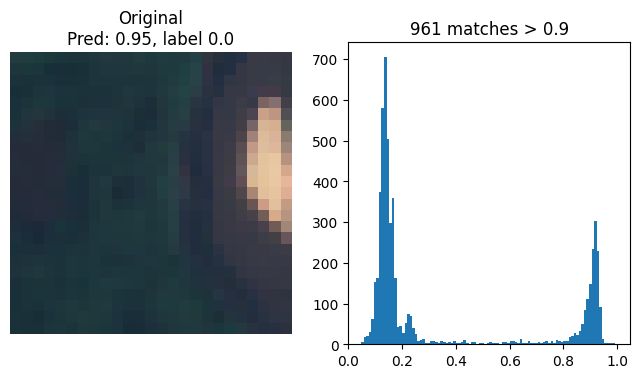

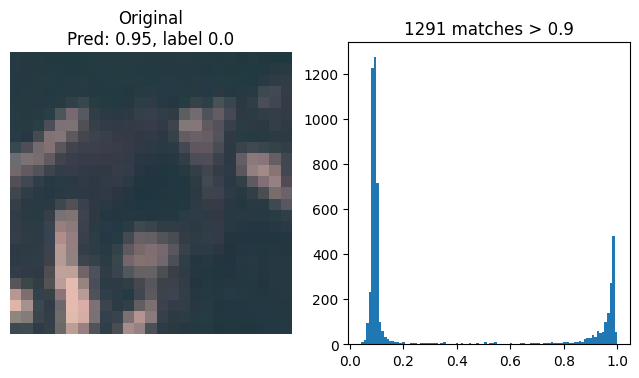

In [180]:
for failure in failures[:10]:
    sample_id = failure
    plt.figure(figsize=(8,4), dpi=100)
    plt.subplot(1,2,1)
    plt.imshow(np.clip(x[sample_id][:,:,3:0:-1], 0, 1))
    plt.title(f"Original\nPred: {preds[sample_id]:.2f}, label {labels[sample_id]}")
    plt.axis('off')
    plt.subplot(1,2,2)
    num_samples = len(x)
    matches = semantic_search(features[sample_id], features, top_k=num_samples)
    scores = [match['score'] for match in matches[0]]
    plt.hist(scores, 100)
    plt.title(f"{np.sum(np.array(scores) > 0.9)} matches > 0.9")
    plt.show()
    

# Autoencoder Test

In [402]:
resolution = 25

input_data_files = ['amazonas_2020_thresh_0.5postraining_patches_2020-01-01_2020-07-01_28px',
                    'amazonas_2020_thresh_0.5negtraining_patches_2020-01-01_2020-07-01_28px',
                    'MinesNeg2018-2020Sentinel_patches_2020-01-01_2020-07-01_28px',
                    'MinesPos2018-2020Sentinel_patches_2020-01-01_2020-07-01_28px',
                    'bolivar_2020_thresh_0.8negtraining_patches_2020-01-01_2020-07-01_28px',
                    'bolivar_2020_thresh_0.8postraining_patches_2020-01-01_2020-07-01_28px',
                    'bolivar_2020-06_negatives_patches_2020-01-01_2020-07-01_28px',
                    '28_px_bolivar_amazonas_v7_validated_cloudy_negatives_448',
                    '28_px_corrupted'
                   ]

images = []
labels = []

data_dir = os.path.join('..', 'data', 'training_data')

for fname in input_data_files:
    with open(os.path.join(data_dir, fname + '_patches.pkl'), 'rb') as f:
        data = pickle.load(f)
        for elem in data:
            patch = dl_utils.pad_patch(elem, resolution)
            images.append(patch)
    with open(os.path.join(data_dir, fname + '_patch_labels.pkl'), 'rb') as f:
        label = pickle.load(f)
        labels = np.concatenate((labels, label))

images = np.array(images)
print(len(images), "samples loaded")
print(sum(labels == 1), "positive samples")
print(sum(labels == 0), "negative samples")
X = dl_utils.normalize(np.copy(images))
X = np.clip(X, 0, 1)

5528 samples loaded
1359 positive samples
4169 negative samples


In [408]:
# Example convolutional autoencoder taken from keras blog
input_shape = np.shape(X[0])
input_img = keras.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2DTranspose(16,(3, 3), strides=2, activation='relu', padding='same')(encoded)
x = layers.Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32,(3, 3), strides=2, activation='relu', padding='valid')(x)


#x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
#x = layers.UpSampling2D((2, 2))(x)
#x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#x = layers.UpSampling2D((2, 2))(x)
#x = layers.Conv2D(16, (3, 3), activation='relu')(x)
#x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='valid')(x)
x = layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='valid')(x)
x = layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='valid')(x)
decoded = layers.Conv2D(input_shape[-1], (3, 3), activation='sigmoid')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Model: "model_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_112 (InputLayer)       [(None, 25, 25, 12)]      0         
_________________________________________________________________
conv2d_469 (Conv2D)          (None, 25, 25, 32)        3488      
_________________________________________________________________
max_pooling2d_276 (MaxPoolin (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_470 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_277 (MaxPoolin (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_471 (Conv2D)          (None, 7, 7, 16)          9232      
_________________________________________________________________
max_pooling2d_278 (MaxPoolin (None, 4, 4, 16)          0 

In [413]:
autoencoder.fit(X, X,
                epochs=32,
                batch_size=16,
                shuffle=True)

Epoch 1/32
346/346 [==============================] - 23s 67ms/step - loss: 0.5214
Epoch 2/32
346/346 [==============================] - 33s 97ms/step - loss: 0.5179
Epoch 3/32
346/346 [==============================] - 24s 70ms/step - loss: 0.5152
Epoch 4/32
346/346 [==============================] - 24s 69ms/step - loss: 0.5143
Epoch 5/32
346/346 [==============================] - 25s 73ms/step - loss: 0.5137
Epoch 6/32
346/346 [==============================] - 26s 76ms/step - loss: 0.5130
Epoch 7/32
346/346 [==============================] - 26s 74ms/step - loss: 0.5125
Epoch 8/32
346/346 [==============================] - 27s 77ms/step - loss: 0.5120
Epoch 9/32
 45/346 [==>...........................] - ETA: 23s - loss: 0.5131

KeyboardInterrupt: 

In [414]:
encoder = keras.Model(input_img, encoded)

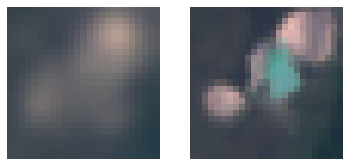

In [472]:
for sample_num in [1638]:
    plt.subplot(1,2,1)
    plt.imshow(autoencoder.predict(X[sample_num:sample_num + 1])[0][:,:,3:0:-1])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(X[sample_num][:,:,3:0:-1])
    plt.axis('off')
    plt.show()

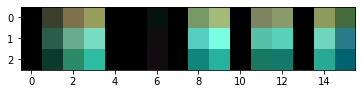

In [288]:
plt.imshow(np.moveaxis(encoder.predict(X[0:1])[0], 0, -1) / 150)